In [2]:
import sys 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
sys.path.append('../')

In [3]:
%load_ext autoreload
%autoreload 2
from database import Magneticum
from relation import Scaling
from relation import Distribution
from relation import Analysis
from relation import RandomForest

In [4]:
def data_manupulation(df):
    dff = df.copy()
    dff.Vnet = dff.Vnet.apply(lambda x: x/1e5)
    dff.Vz = dff.Vz.apply(lambda x: x/1e5)
    dff.Mstar = dff.Mstar.apply(lambda x: np.log(x))
    ss = StandardScaler()
    dff['Vnet'] = ss.fit_transform(dff['Vnet'].values.reshape(-1,1))
    dff['Vz'] = ss.fit_transform(dff['Vz'].values.reshape(-1,1))
    dff['Mstar'] = ss.fit_transform(dff['Mstar'].values.reshape(-1,1))
    dff['M'] = ss.fit_transform(dff['M'].values.reshape(-1,1))
    dff['Yksz'] = ss.fit_transform(dff['Yksz'].values.reshape(-1,1))
    return dff

In [5]:
a = Analysis(50,'140','')

In [6]:
a.distribution.z

0.032637493

In [7]:
df = a.get_dataframe()

Text(0, 0.5, '$V_{z}$')

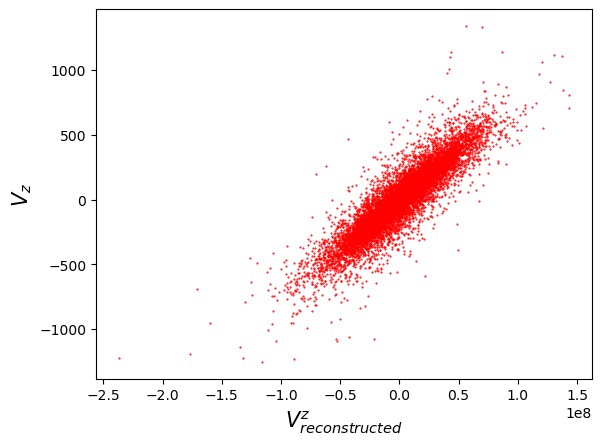

In [8]:
plt.plot(df['Vz'],df['Vlos'],'r.',markersize=1)
plt.xlabel("$V^z_{reconstructed}$",fontsize=15)
plt.ylabel("$V_{z}$",fontsize=15)

In [9]:
np.corrcoef(df['Vz'],df['Vlos'])[0,1]

0.9002092155230011

In [10]:
df.head()

,UID,x[kpc/h],y[kpc/h],z[kpc/h],x_pix,y_pix,i_sector,m500c[Msol/h],r500c[kpc/h],gas_frac,...,Vy,Vz,Vnet,vnet,Mstar,Mgas,Vlos,Yksz,M,Ytsz
0,0,208707.380,203892.310,349705.03,9714,6893,6,1.032820e+15,1239.470,0.122792,...,-7.024034e+07,-4.433932e+07,8.685351e+07,282.734776,4.223201e+13,1.811743e+14,-197.449,-11.521859,34.927744,-8.230696
1,1,314110.310,24347.102,278058.44,14620,15250,15,6.263050e+14,1049.090,0.116260,...,2.602357e+07,-5.794033e+07,8.453292e+07,420.658838,2.612479e+13,1.040203e+14,-256.902,-11.813518,34.427534,-9.135539
2,2,83776.258,206510.050,144915.31,3899,6771,4,7.927850e+14,1134.840,0.121408,...,6.671624e+06,-4.979367e+06,2.812165e+07,210.422788,2.543798e+13,1.375006e+14,-124.361,-12.259982,34.663248,-8.619792
3,3,183729.830,193320.660,332756.00,8551,7385,6,1.800290e+14,692.373,0.112743,...,4.130841e+07,8.060328e+06,9.136059e+07,1151.476184,6.765747e+12,2.899573e+13,-434.947,-12.564427,33.180814,-11.032434
4,4,327315.410,233257.000,209403.95,15235,5526,7,6.558460e+14,1065.330,0.114432,...,5.183772e+07,-4.228684e+07,7.715612e+07,283.361004,2.622119e+13,1.072140e+14,-111.475,-12.618172,34.473622,-9.126199


In [11]:
df.Vnet = df.Vnet.apply(lambda x: x/1e5)
df.Vz = df.Vz.apply(lambda x: x/1e5)
df.Mstar = df.Mstar.apply(lambda x: np.log(x))

In [12]:
df = data_manupulation(df)

In [17]:

project = RandomForest(df)
project.split_data(test_size=0.2)


In [18]:
project.data_df.M_q.value_counts()

Q1    2624
Q2    2623
Q3    2623
Q4    2623
Name: M_q, dtype: int64

In [19]:
project.X_test.M_q.value_counts()

Q1    525
Q3    525
Q4    525
Q2    524
Name: M_q, dtype: int64

In [20]:
project.X_train.M_q.value_counts()

Q1    2099
Q2    2099
Q3    2098
Q4    2098
Name: M_q, dtype: int64

Text(0, 0.5, 'Count')

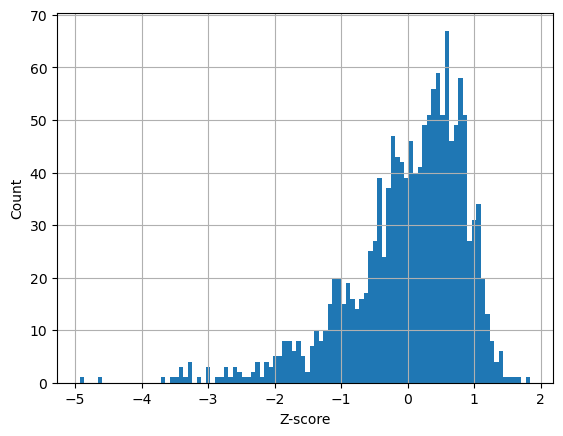

In [30]:
project.get_fit('train',zscore=True).hist(bins=100)
plt.xlabel('Z-score')
plt.ylabel('Count')

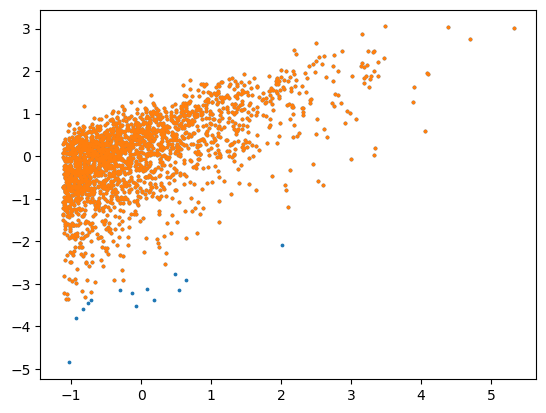

In [15]:
plt.scatter(project.X_train.M,project.y_train,s=3)
project.clean_data()
plt.scatter(project.X_train.M,project.y_train,s=3)

Using [0.0, 0.25] quantile for Mass cut
Using [0.25, 0.5] quantile for Mass cut
Using [0.5, 0.75] quantile for Mass cut
Using [0.75, 1.0] quantile for Mass cut


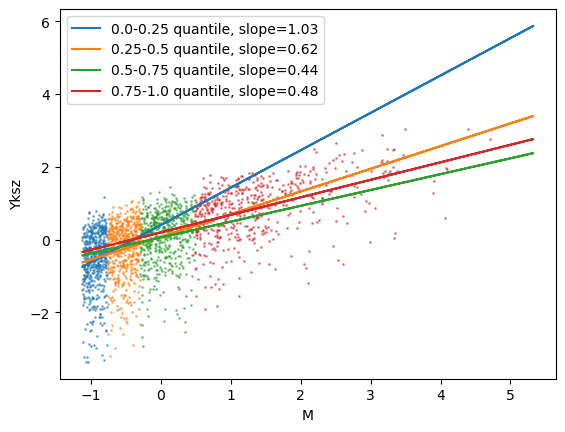

In [17]:
project.plot_fit()

In [31]:

param_grid = {
    'n_estimators': [50, 100, 200, ],
    'max_depth': [10, 20,50,100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 5],
    'max_leaf_nodes' : [5,10,20,50,100]
}

project.find_best_hyperparameters(param_grid)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[CV] END max_depth=10, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_

In [32]:
project.best_hyperparameters

{'max_depth': 10,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 200}

In [16]:
best = {'max_depth': 10,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 50}

In [24]:
best2 = {'max_depth': 5,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 200}

In [25]:
project.best_hyperparameters = best2

In [26]:
project.fit_with_hyperparameters(['M'], 'Yksz')
project.fit_with_hyperparameters(['M','Vz'], 'Yksz')
project.fit_with_hyperparameters(['M','Vlos'], 'Yksz')
project.fit_with_hyperparameters(['M', 'Mstar'], 'Y')
#project.fit_with_hyperparameters(['M','Vz'], 'Y')
#project.fit_with_hyperparameters(['M','Vz', 'Vnet'], 'Y')#\
#project.fit_with_hyperparameters(['M','Vz', 'Vnet','Mstar'], 'Y')

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  

In [80]:
project.fit_with_hyperparameters_cv(['M'], 'Yksz',cv=3)
project.fit_with_hyperparameters_cv(['M','Vz'], 'Yksz',cv=3)
project.fit_with_hyperparameters_cv(['M','Vlos'], 'Yksz',cv=3)
project.fit_with_hyperparameters_cv(['M', 'Mstar'], 'Y',cv=3)
#project.fit_with_hyperparameters(['M','Vz'], 'Y')
#project.fit_with_hyperparameters(['M','Vz', 'Vnet'], 'Y')
project.fit_with_hyperparameters_cv(['M','Vz', 'Vnet','Mstar'], 'Y',cv=3)

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  

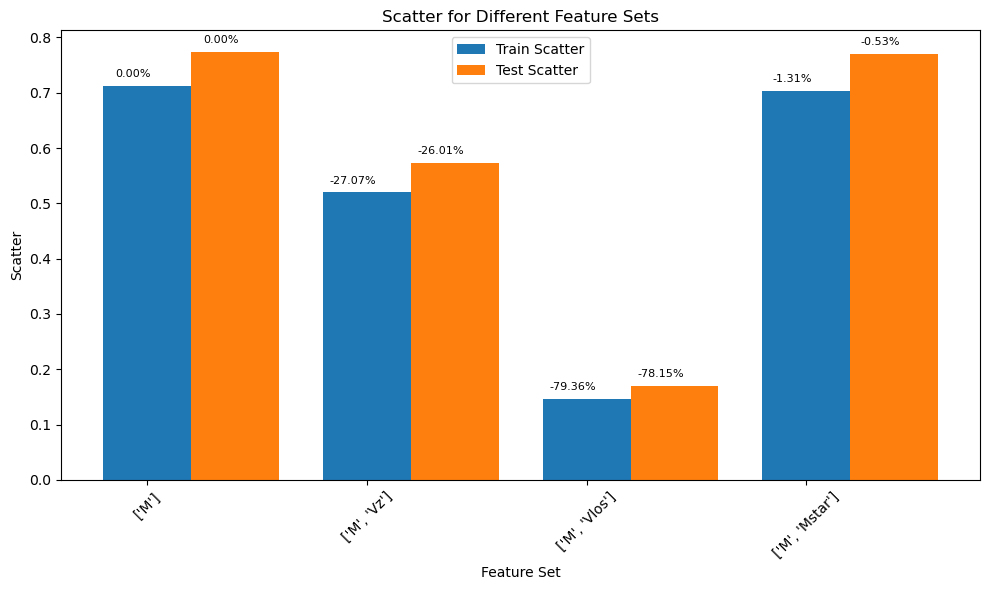

In [19]:

project.plot_scatter_statistics()


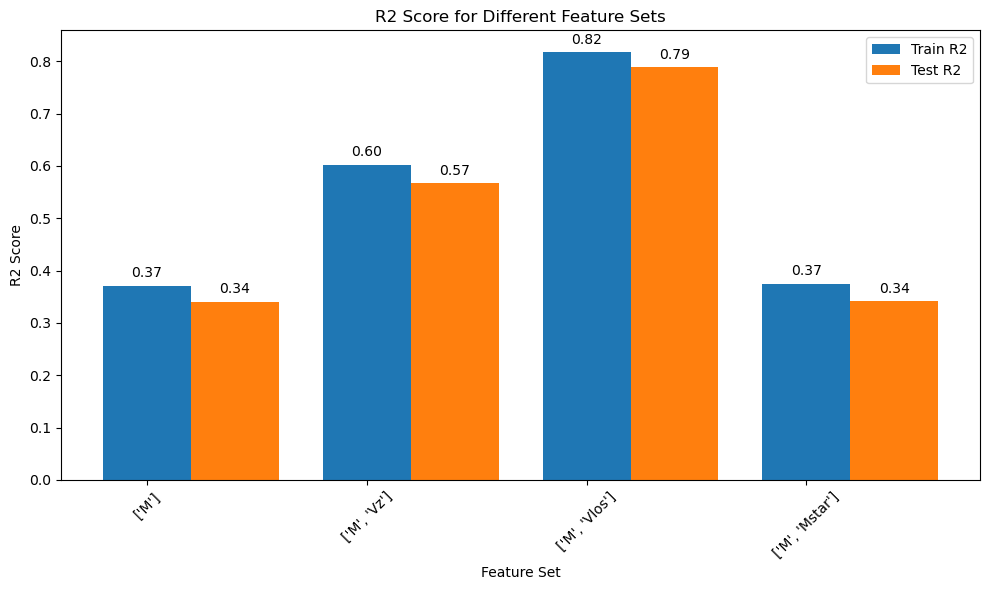

In [27]:
project.plot_r2_statistics()

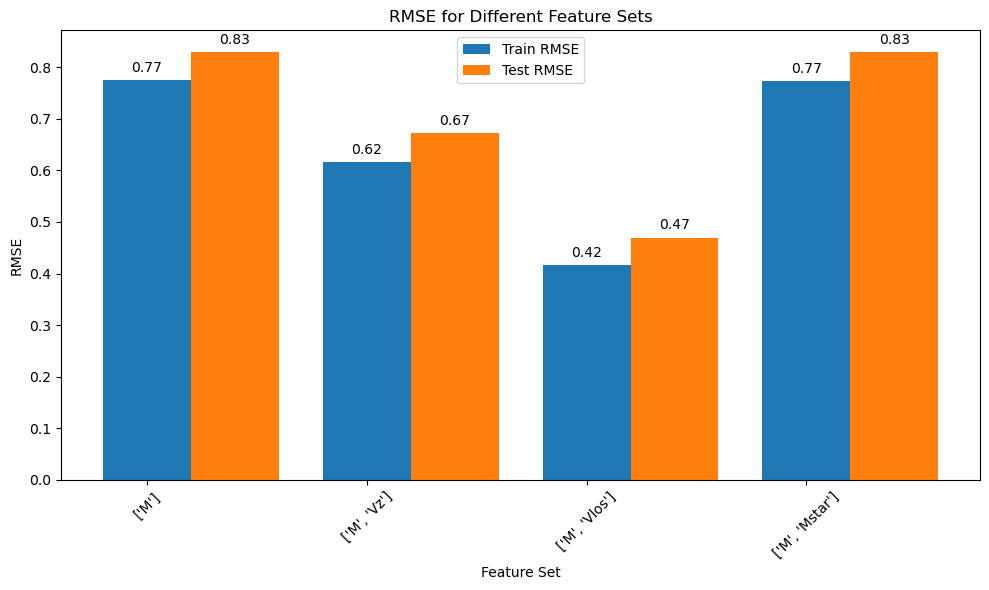

In [28]:
project.plot_RMSE()

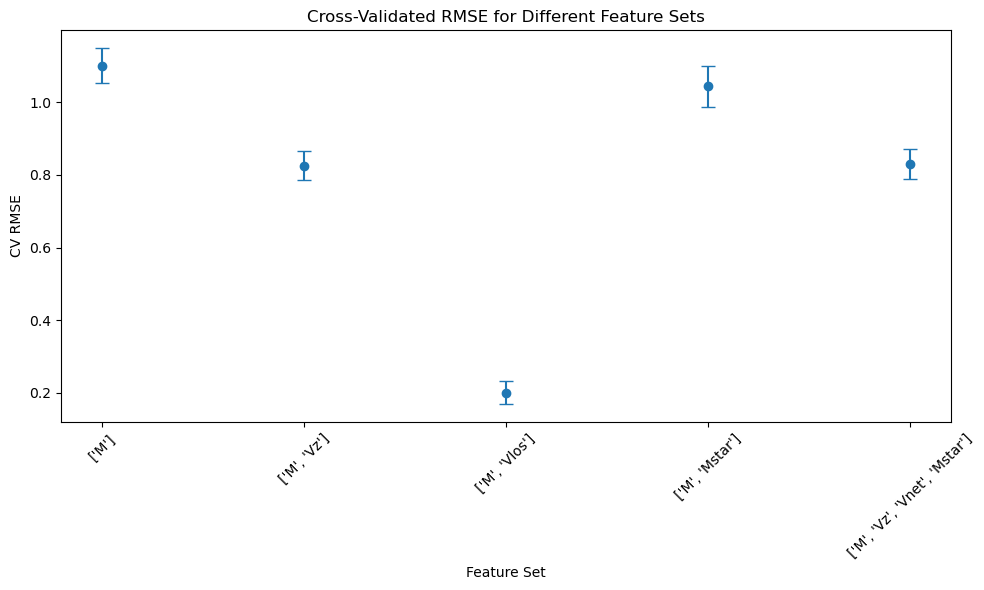

In [84]:
project.plot_cv_rmse()